# Smart flash cards using LLMs

In [1]:
import os
import openai # make sure to pip install openai
import re
import json
import numpy as np
import pandas as pd
from collections import Counter
from typing import Any, Optional, Tuple, Dict, List, NamedTuple, Set
import scipy
import time

from pprint import pprint as pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

import umap
import hdbscan
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import tkinter as tk
from tkinter import ttk

from basic_utils import *
from basic_user_interface import *
from initial_card_processing import *
from knowledge_graph import *
from knowledge_graph_querying import *

2023-03-26 15:46:10.724259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Process initial flashcards to extract info 
Load flashcards from CSV and create json file with saved meta data.

This does not need to be rerun if 'my_flash_cards_general_cards_df_abstraction_groups' file exists.

In [3]:
# process my basic flashcards from online
csv_title = 'my_flash_cards_general' 
verbose=False
cards_df_abstraction_groups = get_cards_df_abstraction_groups_from_front_and_back_csv(csv_title, verbose=verbose)
save_cards_df_to_json(cards_df_abstraction_groups, csv_title + '_cards_df_abstraction_groups')

Card index:  0
global_tokens_used_for_card_reading:  0
Total used tokens: 119  for card index  0
Total used tokens: 157  for card index  1
Total used tokens: 201  for card index  2
Total used tokens: 175  for card index  3
Total used tokens: 150  for card index  4
Total used tokens: 182  for card index  5
Total used tokens: 201  for card index  6
Total used tokens: 147  for card index  7
Total used tokens: 180  for card index  8
Total used tokens: 144  for card index  9
Total used tokens: 126  for card index  10
Total used tokens: 95  for card index  11
Total used tokens: 273  for card index  12
Total used tokens: 135  for card index  13
Total used tokens: 286  for card index  14
Total used tokens: 175  for card index  15
Total used tokens: 218  for card index  16
Total used tokens: 177  for card index  17
Total used tokens: 242  for card index  18
Total used tokens: 172  for card index  19
Card index:  20
global_tokens_used_for_card_reading:  3555
Total used tokens: 222  for card inde

## Build a knowledge graph

In [6]:
# Reload basic cards to start to make knowledge graph 
cards_df = read_cards_df_from_json('my_flash_cards_general_cards_df_abstraction_groups')

print("Cards loaded:", len(cards_df))

Cards loaded: 542


In [3]:
# Build a graph from real flashcard data 
kGraph = KnowledgeGraph(lower_bound_epsilon=0.05)

In [4]:
# Add card deck to kGraph
card_deck = create_card_deck_from_dataframe_of_abstraction_groups(cards_df)
title_list = kGraph.add_card_deck(card_deck, verbose=True)
kGraph.update_all_embeddings(verbose=True)

Adding 540 cards
Recalculating relative abstraction
   Node number:  0 , Title: "Climate Change" at time  0.0
   Node number:  200 , Title: "Ic" at time  0.82
   Node number:  400 , Title: "Variational Lower Bound" at time  2.07
   Node number:  600 , Title: "Optimal" at time  3.54
   Node number:  800 , Title: "Td Learning" at time  4.59
   Node number:  1000 , Title: "Layer" at time  5.35
   Node number:  1200 , Title: "Author" at time  6.12
   Node number:  1400 , Title: "Information Flow" at time  7.02
   Node number:  1600 , Title: "Military" at time  7.66
   Node number:  1800 , Title: "Initialization" at time  9.29
   Node number:  2000 , Title: "Litigation" at time  10.57
   Node number:  2200 , Title: "Hessian" at time  11.52
   Node number:  2400 , Title: "Kulback Liebler Divergence" at time  12.58
   Node number:  2600 , Title: "Timing" at time  13.33
   Node number:  2800 , Title: "2x2" at time  14.19
Updating raw embedding vectors
   Node number:  0 , Title: "Climate Chang

### Visualize graph

#### Build similarity matrix

In [5]:
# Visualize the card-card overlap. This is a bit slow to run (20-30 seconds)

cardIDs = np.array(list(kGraph.cards.keys()))
cardIDs.sort()  # low to high
similarity_metric = np.zeros((len(cardIDs), len(cardIDs)))

name_labels = [kGraph.cards[cardID].topic for cardID in range(len(similarity_metric))]

for cardID1 in cardIDs:
    emb_vec1 = kGraph.cards[cardID1].embedding_vector_trimmed
    similarity_metric[cardID1,cardID1] = 1.0  # diag is 1 by definition
    for cardID2 in cardIDs:
        if cardID2 > cardID1:
            emb_vec2 = kGraph.cards[cardID2].embedding_vector_trimmed
            inner_prod = emb_vec_inner_product(emb_vec1, emb_vec2)
            similarity_metric[cardID1, cardID2] = (inner_prod + 1e-13)/(1.0 + 1e-13)
            similarity_metric[cardID2, cardID1] = (inner_prod + 1e-13)/(1.0 + 1e-13)

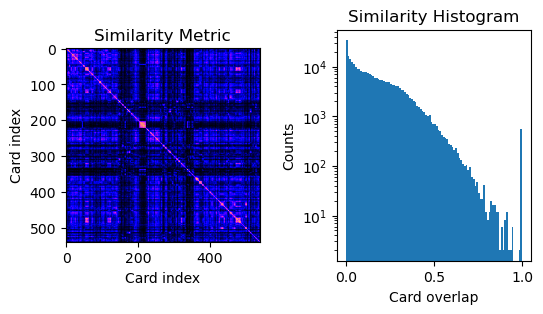

In [6]:
fig, ax = plt.subplots(1,2, figsize=(6, 3))
ax[0].imshow(similarity_metric, vmin=0, vmax=1, cmap='gnuplot2')
ax[0].set_xlabel('Card index')
ax[0].set_ylabel('Card index')
ax[0].set_title('Similarity Metric')
ax[1].hist(similarity_metric.flatten(), bins=100)
ax[1].set_xlabel('Card overlap')
ax[1].set_ylabel('Counts')
ax[1].set_title('Similarity Histogram')
ax[1].set_yscale('log')
plt.subplots_adjust(wspace=0.4)
plt.show()

#### Interactive clustering visualization
Create a low dimensional clustered representation. Scan cursor over clusters to see what is in them. Adjust cluster size with slider.

In [7]:
# Make and adjustable clustering algorithm based on desired size after UMAP

# Convert similarity to distance
distance_metric = 1 - similarity_metric

# Apply UMAP dimensionality reduction
reducer = umap.UMAP(metric="precomputed", random_state=42)
embedding = reducer.fit_transform(distance_metric)

def plot_clusters(min_cluster_size):
    # Perform HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, gen_min_span_tree=True)
    cluster_labels = clusterer.fit_predict(embedding)

    # Create an interactive plot
    fig = px.scatter(x=embedding[:, 0], y=embedding[:, 1], color=cluster_labels, hover_name=name_labels,
                     color_continuous_scale=px.colors.qualitative.Dark24, width=600, height=600)
    fig.update_traces(marker=dict(size=8))
    fig.show()



# Create an interactive slider widget to control the min_cluster_size parameter
slider = widgets.IntSlider(value=5, min=2, max=50, step=1, description='Min Cluster Size:')
widgets.interact(plot_clusters, min_cluster_size=slider)

/Users/thomashartke/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


interactive(children=(IntSlider(value=5, description='Min Cluster Size:', max=50, min=2), Output()), _dom_clas…

<function __main__.plot_clusters(min_cluster_size)>

#### Display a few nodes/cards

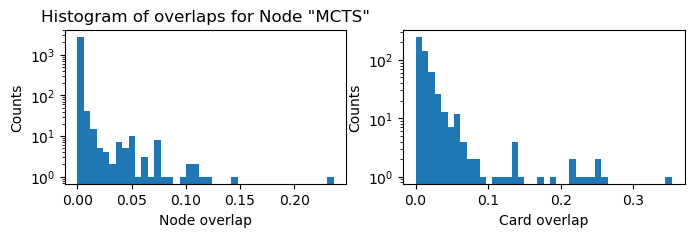

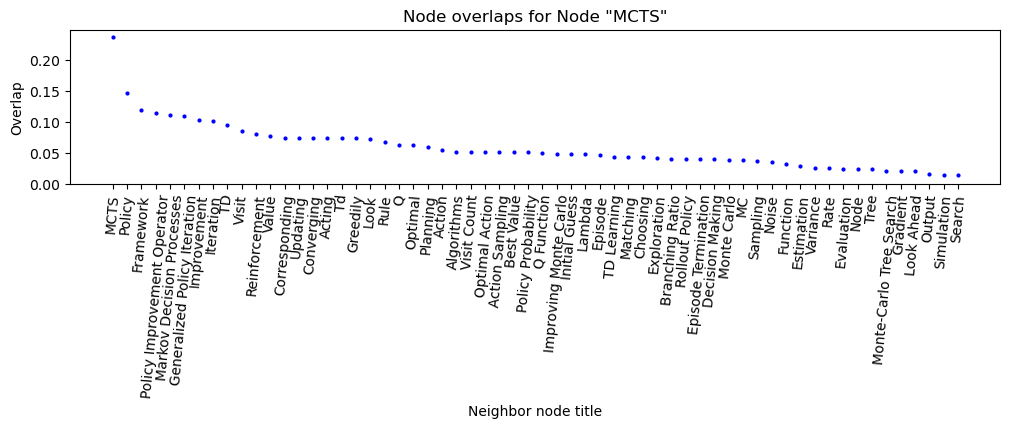

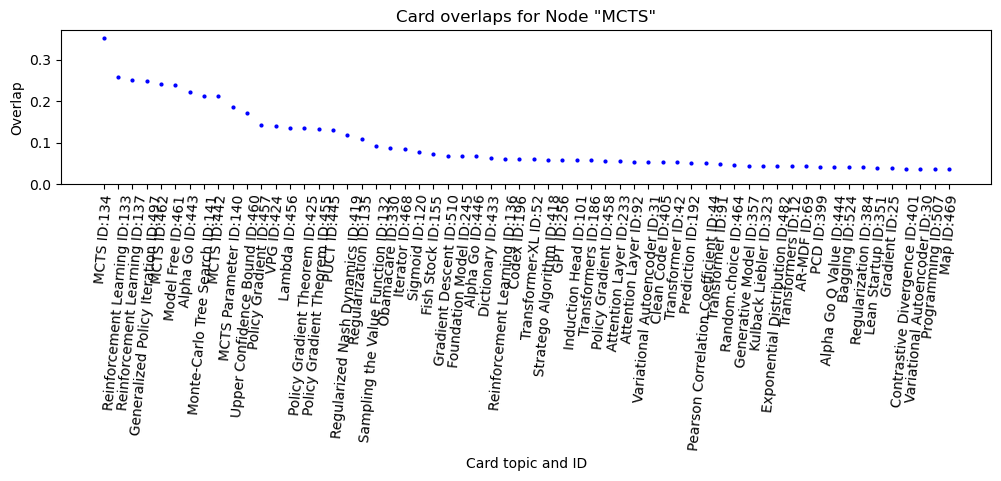

Topic: Autoregressive Model
Question: Describe the relation between autoregressive models, flow models, and latent variable models in 1 sentence.
Answer: Autoregressive models are general prediction models
Flow models can handle continuous data and disentangle the latent space
Latent variable models compress the latent space to enhance inference. 
Key ideas:
1. Autoregressive models are general prediction models.
2. Flow models can handle continuous data and disentangle the latent space.
3. Latent variable models compress the latent space to enhance inference.



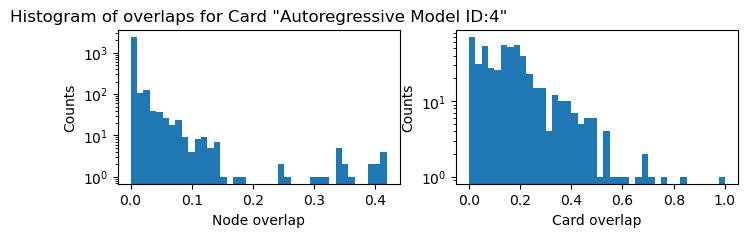

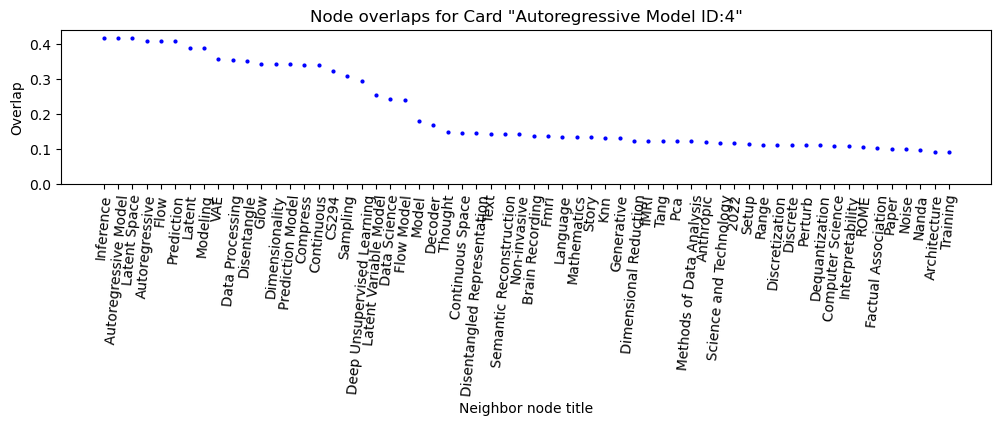

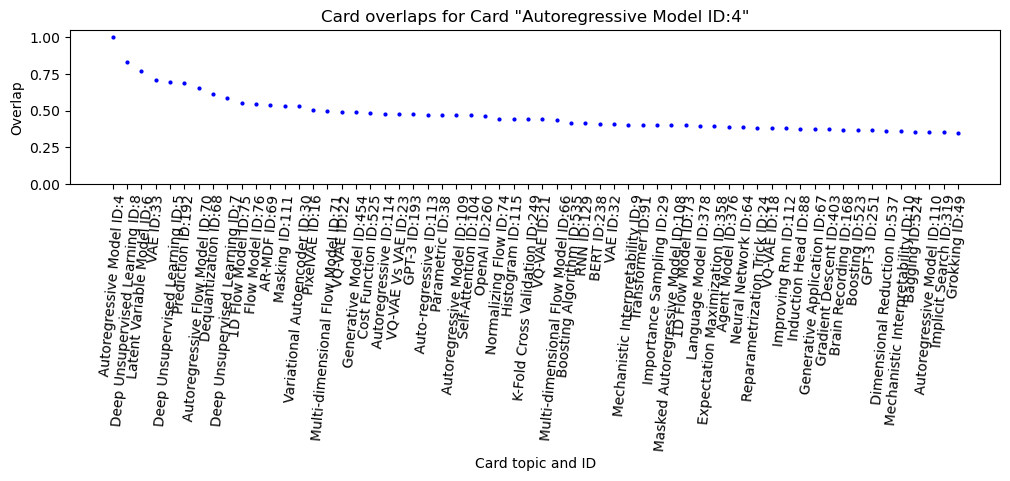

In [8]:
node_title = 'MCTS'
node = kGraph.nodes[node_title]
kGraph.display_object_overlaps(node)

card = kGraph.cards[4]
card.display(verbose=True)     
kGraph.display_object_overlaps(card)

## User interface using ChatGPT
Added a chatGPT user interface to generate, select, answer, and save new questions. 
For details see basic_user_interface.py files

#### Generating new questions (flexible configuration):
1. Generate further questions based on desired topic, and desired goal. This generates questions based on clusters and style of existing flashcards in graph.
2. Generate further questions based on existing new questions
3. Generate further questions based on similar questions already in graph (viewed in a separate window). 

#### Triage new questions:
1. Choose which new questions to keep and explore further.
2. Generate new questions about similar topics.
3. Ultimately select which questions to answer.

#### Answering questions:
1. Use ChatGPT to answer the desired new questions. 
2. View and edit these answers and questions to desired accuracy.
3. Save them to the knowledge graph and update embeddings, and also save to original long term JSON file storage. 

In [5]:
# Launch explorer and follow instructions within
exploration_data = launch_explorer(kGraph, cards_df) 

Generating new questions based on random card clusters, related cards in graph, and existing new questions
Resaved main info
Resaved main info
Answering new questions
Resaved main info
0
1
Adding 2 cards
Recalculating relative abstraction
   Node number:  0 , Title: "Science" at time  0.0
Updating raw embedding vectors
   Node number:  0 , Title: "Science" at time  0.0
Updating all node embeddings:
   Node number:  0 , Title: "Science" at time  0.0
   Node number:  200 , Title: "Error" at time  1.49
   Node number:  400 , Title: "Landfill" at time  1.86
   Node number:  600 , Title: "Superposition Detection" at time  1.93
   Node number:  800 , Title: "Loss Function" at time  2.06
   Node number:  1000 , Title: "Information Processing" at time  2.17
   Node number:  1200 , Title: "Autotroph" at time  2.28
   Node number:  1400 , Title: "Weight" at time  2.37
   Node number:  1600 , Title: "Actual Agent" at time  2.47
   Node number:  1800 , Title: "Non-renewable" at time  2.54
   Node 

/Users/thomashartke/Documents/GitHub/LLM-Exploration/knowledge-graph-from-GPT-3/basic_user_interface.py:483: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.cards_df = self.cards_df.append(row, ignore_index=True)
/Users/thomashartke/Documents/GitHub/LLM-Exploration/knowledge-graph-from-GPT-3/basic_user_interface.py:483: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.cards_df = self.cards_df.append(row, ignore_index=True)


## OLD method: Query knowledge graph

##### Question examples

In [5]:
################## Example questions ##################

# Actual flashcards, or very close. It seems to usually solve these.
# "What is the most basic model of how natural environments determine major animal types in a given biome?"
# "What are good practices for a function input and output when coding?"
# "What are two major problems with existing LLMs like ChatGPT?"
# "In the stratego paper, what is the regularized nash dynamics algorithm most similar to in other reinforcement learning algorithms?"

# Hard
# "If I am trying to fit a function, and it isn't very accurate, what method can I use to improve accuracy?"

# Easier
# "Why is boosting useful?"
# "Why do language models sometimes give wildly wrong answers when predicting text?"
# "What is the best way to learn new information about a new field of science?"
# "Why should I care about determinants?"
# "What happens in the drug approval process?"
# "What major event happened in Texas in 2021?"
# "How can I find the minimum of a function with a computer program?"
# "What probability distribution deals with repeated draws from a set with replacement?"
# "How hard is it to calculate the determinant of a matrix?"
# "What are ways to impove the scientific funding process?"
# "What is a multimodal neuron in a neural network?"
# "What will the probability distribution be if I count how many times something with a fixed rate happens over some period of time?"
# "When did the modern plants come into existence in evolutionary history?"
# "What is gradient descent?"
# "What is the sticky engine of growth for a startup?"
# "What is Jim Allison famous for?"
# "What modern encryption system works pretty well?"
# "How can I sort a list in python?"
# "How does a 3D metals printer work?"

# Not in distribution
# "When did the modern coral come into existence in evolutionary history?" # testing a case that wasn't present 
# "What causes the band structure of atoms in a periodic lattice to be sinusoidal?"
# "What remains to be determined about the structure of fermion pairs in the spin-imbalanced Hubbard model?"

# Fake information
# "A fleegdorf is stuck in my garage, what do I do?"


##### Exploring

In [63]:
flashcardQuestion = "What happens in the drug approval process?"
num_cards_to_show = 10
verbose = True
extra_verbose = True
outside_knowledge_allowed=True

In [64]:
# Gather the initial subject list 
question_subject_list = get_refined_subject_list_from_question(flashcardQuestion, kGraph,
                                                               num_cards_to_show=num_cards_to_show, verbose=verbose,
                                                              extra_verbose=extra_verbose)

Used tokens: 67
Question: {What is meaningfully different about indirect and direct patent infringement with regards to intent? }
Extracted key words and concepts: ["Knowledge", "Business", "Legal", "Law", "Intellectual Property", "Intent", "Direct", "Indirect", "Patent Infringement", "Patent", "Infringement"]

Question: {What is meaningfully different about indirect and direct patent infringement with regards to intent? }
Extracted key words and concepts: ["Knowledge", "Business", "Legal", "Law", "Intellectual Property", "Intent", "Direct", "Indirect", "Patent Infringement", "Patent", "Infringement"]

Question: {List comprehension examples in Python }
Extracted key words and concepts: ["Knowledge", "Science", "Mathematics", "Computer Science", "Technology", "Python", "Programming", "List Comprehension", "Expression", "Item", "Condition", "Fruit", "Newlist", "Boolean"]

Question: {Eras of science and discovery (methods) according to Max Welling }
Extracted key words and concepts: ["Kno

In [65]:
# Answer the question
flashcardAnswer = get_answer_from_question_with_subject_list(flashcardQuestion, question_subject_list, kGraph,
                                          num_cards_to_show=num_cards_to_show, 
                                                             outside_knowledge_allowed=outside_knowledge_allowed,
                                                             verbose=verbose,
                                                              extra_verbose=extra_verbose)

Used tokens: 102
Professor Smith has provided the following 10 questions and answers to the class to review:
Question: {Compare and the costs and benefits of wind and solar to nuclear energy }
Answer: {Cost: The upfront cost of building wind and solar facilities is generally lower than the cost of building a nuclear power plant. However, the cost of generating electricity from nuclear energy is often lower than the cost of generating electricity from wind or solar, especially over the long term, due to the higher capacity factor (the amount of electricity a power plant generates compared to its theoretical maximum output) of nuclear plants. Also land use is much higher for wind and solar. 
Reliability: Nuclear power plants have a very high capacity factor and can operate continuously for extended periods of time, making them a reliable source of electricity. In contrast, the output of wind and solar facilities is dependent on weather conditions, which can be variable.
Further concerns:

In [66]:
generated_further_question_list = get_suggested_further_questions_from_question_and_subject_list(flashcardQuestion, question_subject_list, kGraph,  
                                                               num_seed_cards_to_show=4,
                                                               num_related_cards_to_show=5,
                                                               num_questions_to_generate=4,
                                                                                         increasing_abstraction=True,
                                                                                                 temperature=0.25,
                                                               verbose=verbose,
                                                              extra_verbose=extra_verbose)

Used tokens: 61
Professor Smith has provided the following groups of questions to the class to review. Within each group of questions, successive questions cover topics of increasing abstraction. All questions are meant to be sufficiently detailed to be understandable without further context:

Related questions in order of increasing abstraction:
Q: {How are credit card rewards an example of a zero sum game? }
Q: {Is a trade secret something you apply for? }
Q: {What is the theory of why the history of world Gross Domestic Product (GDP) growth is super-exponential? Why is this important? }
Q: {How can innovation and technology reduce interest rates? Why is this unintuitive? }
Q: {What was the incentive for the first company to offer credit card rewards? }

Related questions in order of increasing abstraction:
Q: {What was the goal of the CLIP paper (Jan 2021)?}
Q: {Key components of modern large pretrained language models (architecture and training method) }
Q: {How does the Dalle-2 pa

In [16]:
# Enhance the detail of the question
flashcardQuestion_enhanced = get_enhanced_question_from_question_and_subject_list(flashcardQuestion, question_subject_list, kGraph,
                                                        num_cards_to_show=num_cards_to_show, verbose=verbose,
                                                              extra_verbose=extra_verbose)

Used tokens: 15
Professor Smith has provided the following questions to the class to review:
Question: {RSA encryption details: 
What is the order of a multiplicative ring of size p with p prime?
What about a ring mod N with N=p*q and p and q prime? }

Question: {What are two formulas to write the determinant of a square matrix? }

Question: {Properties of Hermitian matrices }

Question: {RSA encryption details: 
What is the order of a multiplicative ring? }

Question: {How to simplify input arguments to functions to prevent forgetting input format? }

Question: {Importance of determinants }

Question: {What happens to the determinant of the product of two matrices }

Question: {Determinant algorithm complexity }

Question: {Formula for the inverse of a matrix using the determinant }

Question: {3 sat (the 3 satisfiability problem): is it or of a bunch of ands, or and of a bunch of ors?}


A student is currently studying the following question:
Question: {How hard is it to calculate th

#### Make entire flashcard better

In [22]:
# Enhance the detail of the question
cardID = 401
flashcardQuestion = kGraph.cards[cardID].question
flashcardAnswer = kGraph.cards[cardID].answer
# flashcardConceptList = kGraph.cards[cardID].concepts.get_concepts_list()
print(flashcardQuestion)
# print(flashcardConceptList)
print(flashcardAnswer)

What are the steps involved in contrastive divergence? 
We want to sample the energy of a Boltzmann machine model (on average) for computing a gradient in MLE.
To do so, we start with a real sample in the visible layer, get probability sample of hidden layer, then go back and forth, until we converge to something representative of the model (MC estimate). 


In [37]:
# Gather the initial subject list 
question_subject_list = get_refined_subject_list_from_question(flashcardQuestion, kGraph,
                                                               num_cards_to_show=num_cards_to_show, verbose=verbose,
                                                              extra_verbose=extra_verbose)

Used tokens: 51
Question: {What is Jensen-Shannon divergence, and what properties of basic Kulback Liebler divergence make it useful.
What is it used in (what type of reinforcement learning?) }
Extracted key words and concepts: ["Reinforcement Learning", "Maximum Likelihood", "Generative Adversarial Networks", "Model", "Data", "Divergence", "Probability", "Jensen-Shannon", "Kulback Liebler", "Generative Adversarial Network"]

Question: {How many landfills are there in the united states? }
Extracted key words and concepts: ["Human Impact", "Pollution", "Regulation", "Environment", "United States", "Waste Management", "Landfill", "United State", "2000", "EPA"]

Question: {Two types of programming }
Extracted key words and concepts: ["Computing", "Problem-solving", "Function", "Algorithmic", "Optimization", "Dynamic", "Gradient", "Programming", "Problem", "Sub-Problem", "Algorithm", "Step"]

Question: {RSA encryption why does it work, in 1 sentence?}
Extracted key words and concepts: ["Kn

In [24]:
# Make updated phrasing
flashcard_enhanced = get_enhanced_flashcard_from_question_and_answer_and_subject_list(flashcardQuestion, flashcardAnswer, 
                                                                                      question_subject_list, kGraph,
                                                        num_cards_to_show=num_cards_to_show, verbose=verbose,
                                                              extra_verbose=extra_verbose)

Used tokens: 114
Professor Smith has provided the following question and answer pairs to the class to review:
Question: {What are the two approaches to regularization in ML? }
Answer: {1. Add noise to the learning process so that specific solutions aren't overfit. Examples of this are the dropout method and batchnorm method in neural network training. 
2. Penalize the size of parameters used in the model, or the number of parameters used. This can be done using the cost function in gradient descent, for example.}

Question: {What is the intuition about the size of the Fisher information for a distribution and some data? }
Answer: {If Fisher information is large at the MLE, this means you are at a very strongly peaked maximum of the likelihood. So your certainty on the parameters will correspondingly be high. }

Question: {What problem is Beta-VAE trying to solve, and how does it solve it? }
Answer: {Vanilla VAE doesn't have a strong prior to learn disentangled latent variables. Ie tuni

## OLD method: Cluster cards into a hierarchy

In [26]:
# Functions for first clustering within a similarity metric

def get_ordered_IDs_by_similarity_to_ID(similarity_metric, cluster_IDs_list, target_ID):
    similarity_vals_presort = similarity_metric[target_ID][cluster_IDs_list]
    ordered_ID_inds = np.flip(np.argsort(similarity_vals_presort))
    ordered_IDs = np.array(cluster_IDs_list)[ordered_ID_inds]
    return ordered_IDs

def get_sub_similarity_metric(similarity_metric, sub_inds_list):
    return np.copy(similarity_metric[sub_inds_list][:,sub_inds_list])

def get_cluster_quality(similarity_metric, cluster_IDs_list, target_ID, cluster_size_scaling=4.0):
    
    def get_log_ratio_vals(submat_self_similarities):

        def get_array_without_diag(A):
            return A[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1)
        # for mean values, may want to remove diagonal
        submat_self_similarities_offdiag = get_array_without_diag(submat_self_similarities)
        off_diag_mean_vals = submat_self_similarities_offdiag.mean(axis=0)

        min_vals = submat_self_similarities.min(axis=0)
        # mean_vals = submat_self_similarities.mean(axis=0)

        zip_min_mean_vals = zip(min_vals, off_diag_mean_vals)
        log_ratio_vals = np.array([np.log(min_val/mean_val) 
                                   for min_val, mean_val in zip_min_mean_vals])
        return log_ratio_vals
    
    similarities_to_target = similarity_metric[target_ID][cluster_IDs_list]
    avg_similarity_to_target = np.average(similarities_to_target)
    
    submat_of_cluster = get_sub_similarity_metric(similarity_metric, cluster_IDs_list)
    log_ratio_vals = get_log_ratio_vals(submat_of_cluster)
    log_scaling = 1.0/cluster_size_scaling
    return avg_similarity_to_target * np.log(len(cluster_IDs_list)) + log_scaling * np.sum(log_ratio_vals)

def get_best_approximate_cluster_relative_to_ID_with_desired_size(similarity_metric, target_ID, 
                                                         cluster_size_scaling=4.0, 
                                                         verbose=False):
    max_IDs_to_check = 50
    ordered_IDs = get_ordered_IDs_by_similarity_to_ID(similarity_metric, range(len(similarity_metric)), target_ID)

    # Get approximate best first order cluster 
    quality_vals = []
    ordered_ind_max_vals = []
    ordered_ind_sets = []
    for ordered_ind_max in range(max_IDs_to_check):
        cluster_IDs_list = ordered_IDs[0:ordered_ind_max+1]
        quality_metric = get_cluster_quality(similarity_metric, cluster_IDs_list, target_ID, 
                                                               cluster_size_scaling=cluster_size_scaling)
        # Append measurement
        quality_vals.append(quality_metric)
        ordered_ind_max_vals.append(ordered_ind_max)
        ordered_ind_sets.append(cluster_IDs_list)
        
        if quality_metric < 0: # Then we will probably just get worse from here. Stop
            break
    
    # Find argmax 
    best_quality_ind = np.argmax(quality_vals)
    best_set_initial_pass = ordered_ind_sets[best_quality_ind]
    current_best_quality_val = quality_vals[best_quality_ind]
    
    if verbose:
        print('Initial results, with best quality value:', current_best_quality_val, 
              ' and set:', best_set_initial_pass)
        plt.plot(ordered_ind_max_vals, quality_vals)
        plt.show()
        
    return best_set_initial_pass

def get_best_revised_cluster_relative_to_ID_with_desired_size(similarity_metric, target_ID, best_set_initial_guess, 
                                             num_max_revisit_passes=50,
                                             cluster_size_scaling=4.0, 
                                             verbose=False):
    how_much_larger_set_to_check = 2
    
    best_set = best_set_initial_guess
    ordered_IDs = get_ordered_IDs_by_similarity_to_ID(similarity_metric, range(len(similarity_metric)), target_ID)
    max_IDs_to_check = len(best_set) * how_much_larger_set_to_check

    # Loop through and check if adding or removing single cards is worse or better. 
    for _iteration in range(num_max_revisit_passes):       
        
        current_best_quality_val = get_cluster_quality(similarity_metric, list(best_set), target_ID,
                                                                       cluster_size_scaling=cluster_size_scaling)
        if verbose:
            print('iteration number', _iteration, ' with current best set: ', best_set, ' and best quality val', current_best_quality_val)
        
        quality_vals = []
        testID_vals = []
        new_test_sets = []
        for ordered_ind, testID in enumerate(ordered_IDs[0:max_IDs_to_check]):
            new_test_set = np.copy(best_set)
            if testID in best_set:
                new_test_set = np.setdiff1d(new_test_set, testID)
            else:
                new_test_set = np.append(new_test_set, testID)

            if len(new_test_set) > 0: # only consider new sets that have nonzero size
                cluster_IDs_list = list(new_test_set)
                quality_metric = get_cluster_quality(similarity_metric, cluster_IDs_list, target_ID,
                                                                       cluster_size_scaling=cluster_size_scaling)

                quality_vals.append(quality_metric)
                testID_vals.append(testID)
                new_test_sets.append(new_test_set)

        
        if np.max(quality_vals - current_best_quality_val) > 0:
            changed_ID = testID_vals[np.argmax(quality_vals)]
            if verbose:
                if changed_ID in best_set:
                    print('  removed card ',changed_ID)
                else:
                    print('  added card ',changed_ID)
            best_set = new_test_sets[np.argmax(quality_vals)]
            current_best_quality_val = np.max(quality_vals)
        else:
            # There was no improvement for any proposed change, so stop iterating 
            break
        
    ordered_IDs_list_result = get_ordered_IDs_by_similarity_to_ID(similarity_metric, list(best_set), target_ID)

    return ordered_IDs_list_result


def get_best_first_order_cluster_relative_to_ID_with_desired_size(similarity_metric, target_ID, 
                                             num_max_revisit_passes=50,
                                             cluster_size_scaling=4.0, 
                                             verbose=False):

    best_set_initial_pass = get_best_approximate_cluster_relative_to_ID_with_desired_size(similarity_metric, target_ID, 
                                                                     cluster_size_scaling=cluster_size_scaling,
                                                                     verbose=verbose)
    
    ordered_IDs_result = get_best_revised_cluster_relative_to_ID_with_desired_size(similarity_metric, target_ID, best_set_initial_pass, 
                                                 num_max_revisit_passes=num_max_revisit_passes,
                                                 cluster_size_scaling=cluster_size_scaling, 
                                                 verbose=verbose)
    
    return ordered_IDs_result
   

In [27]:
# Function for high level clustering of a similarity metric

def remove_complete_subsets(clusters_IDgroups_list):
    # Removes clusters that are a complete subset of another cluster.
    # Returns clusters in order of decreasing size
    
    # Get clusters in order of increasing size. 
    cluster_inds_increasing_size = np.argsort(np.array([len(cluster_IDgroup) for cluster_IDgroup in clusters_IDgroups_list]))
    ordered_clusters_IDgroups_list = [clusters_IDgroups_list[cluster_ind] for cluster_ind in cluster_inds_increasing_size]

    # For each cluster, loop through other clusters and check if its a strict subset
    # If it is not a strict subset of any, then keep it in the final list. 
    final_clusters_IDgroups_list = []
    for cluster_ind_test, cluster_IDgroup_test in enumerate(ordered_clusters_IDgroups_list):
        is_subset = False
        for cluster_IDgroup_potential_superset in ordered_clusters_IDgroups_list[cluster_ind_test + 1:]: # only loop over larger ones
            if set(cluster_IDgroup_test).issubset(set(cluster_IDgroup_potential_superset)):
                is_subset = True 
        if not is_subset:
            final_clusters_IDgroups_list.append(cluster_IDgroup_test)
    
    final_clusters_IDgroups_list.reverse() # report in order of decreasing size at end 
    
    return final_clusters_IDgroups_list

def get_best_clusters_with_desired_size(similarity_metric,
                                             meta_cluster_size_scaling=0.75, # sets the overall precision of clusters. Less precise = larger clusters
                                             verbose=False):
    
    # Finds best clusters by scanning the sensitivity of the first order clustering metric
    # and finding point where it is best quality. 

    # Set up some basic parameters 
    cluster_score_tolerance = 0.02
    cluster_size_scaling_pow_min = -5
    cluster_size_scaling_pow_max = 6
    cluster_size_scaling_arr = 2 ** np.linspace(cluster_size_scaling_pow_min, cluster_size_scaling_pow_max, 
                                                2*(cluster_size_scaling_pow_max - cluster_size_scaling_pow_min + 1))

    significant_clusters_unique_tuple_id_list = []
    significant_clusters_IDgroups_list = []
    significant_cluster_score_list = []

    for target_ID in range(len(similarity_metric)):

        cluster_score_vs_cluster_size = []
        cluster_ID_list_vs_cluster_size = []
        prev_scaled_cluster_score = -1 # for reference 

        # Loop through various low level clustering target sizes to find one with best exclusion around this ID
        for cluster_size_scaling in cluster_size_scaling_arr:
            proposed_ID_list_this_cluster_size = get_best_first_order_cluster_relative_to_ID_with_desired_size(similarity_metric, target_ID, 
                                                             cluster_size_scaling=cluster_size_scaling, 
                                                             verbose=verbose)

            # Get clusters around each of the proposed items in this new cluster 
            proposed_reverse_ID_sets_this_cluster_size = []
            for proposed_ID in proposed_ID_list_this_cluster_size:
                proposed_reverse_ID_list_this_cluster_size = get_best_first_order_cluster_relative_to_ID_with_desired_size(similarity_metric, proposed_ID, 
                                                                 cluster_size_scaling=cluster_size_scaling, 
                                                                 verbose=verbose)
                proposed_reverse_ID_sets_this_cluster_size.append(proposed_reverse_ID_list_this_cluster_size)

            # Gather metric for success rate
            proposed_num_IDs = len(proposed_ID_list_this_cluster_size)
            inclusion_success_rate_list = []
            exclusion_success_rate_list = []

            for proposed_reverse_ID_set in proposed_reverse_ID_sets_this_cluster_size:
                reference_set = set(proposed_ID_list_this_cluster_size)
                test_set = set(proposed_reverse_ID_set)
                extra_IDs = test_set.difference(reference_set)
                missing_IDs = reference_set.difference(test_set)

                min_success_val_cutoff = 1e-10
                exclusion_success_rate_list.append(max(1.0 -len(extra_IDs) / proposed_num_IDs, min_success_val_cutoff))
                inclusion_success_rate_list.append(max(1.0 -len(missing_IDs) / proposed_num_IDs, min_success_val_cutoff))

            exclusion_success_rate_list = np.array(exclusion_success_rate_list)
            inclusion_success_rate_list = np.array(inclusion_success_rate_list)
            inclusion_log_success_min = np.log(np.min(inclusion_success_rate_list))
            exclusion_log_success_min = np.log(np.min(exclusion_success_rate_list))
            meta_log_scaling = 1.0/meta_cluster_size_scaling

            scaled_cluster_score = np.log(proposed_num_IDs)  + meta_log_scaling * (inclusion_log_success_min + exclusion_log_success_min)/2.0

            cluster_score_vs_cluster_size.append(scaled_cluster_score)
            cluster_ID_list_vs_cluster_size.append(proposed_ID_list_this_cluster_size)

            if scaled_cluster_score < prev_scaled_cluster_score : # probably not going to get better
                break
            prev_scaled_cluster_score = scaled_cluster_score

        # Gather result and take best quality cluster within tolerance
        cluster_score_vs_cluster_size = np.array(cluster_score_vs_cluster_size)
        max_cluster_score = np.max(cluster_score_vs_cluster_size)
        cluster_ind_with_max_score = np.max(np.where(np.abs(cluster_score_vs_cluster_size - max_cluster_score) < cluster_score_tolerance)[0])
        best_cluster_ID_list = cluster_ID_list_vs_cluster_size[cluster_ind_with_max_score]

        if max_cluster_score < 0:  # Ignore really bad clusters. Replace with the original ID only. 
            max_cluster_score = 0
            best_cluster_ID_list = [target_ID]

        cluster_unique_tuple_id = tuple(sorted(best_cluster_ID_list)) # for checking if this exact cluster is already found at this level
        

        if not (cluster_unique_tuple_id in significant_clusters_unique_tuple_id_list):
            # Then we found a new cluster, so keep it 
            significant_clusters_unique_tuple_id_list.append(cluster_unique_tuple_id)
            significant_clusters_IDgroups_list.append(best_cluster_ID_list)
            significant_cluster_score_list.append(max_cluster_score)
            
    # Lastly, loop back through and check if each cluster is a strict subset of all the other ones. 
    significant_clusters_IDgroups_list = remove_complete_subsets(significant_clusters_IDgroups_list)
    
    print('  Clusters identified: ', len(significant_clusters_IDgroups_list))

    # significant_clusters_IDgroups_list is a list of the IDs relative to THIS similarity metric! 
    return significant_clusters_IDgroups_list

In [28]:
# Functions to extract amd combine embeddings, and similarity metric

# def get_emb_vec_list_from_cluster_cardIDs(prev_significant_clusters_cardIDs_list,
#                                            intersection_threshold_amount, knowledgeGraph):
#     # Goes through and gets the ID group for each new cluster
#     # Then combines data from all stuff contained in that group. 

#     global_emb_vec_list = []
#     for cluster_cardIDs in prev_significant_clusters_cardIDs_list:
#         # Gather stuff from within this card 
#         emb_vec_list = [knowledgeGraph.cards[_cardID].embedding_vector_trimmed for _cardID in cluster_cardIDs]
#         cluster_emb_vec_untrimmed = emb_vec_intersection_with_threshold(emb_vec_list, knowledgeGraph, 
#                                                                         intersection_threshold_amount)
#         cluster_emb_vec = trim_embedding_vector(cluster_emb_vec_untrimmed)
#         global_emb_vec_list.append(cluster_emb_vec)
        
#     return global_emb_vec_list


def get_emb_vec_list_from_cluster_cardIDs(prev_significant_clusters_cardIDs_list, knowledgeGraph):
    # Goes through and gets the ID group for each new cluster
    # Then combines data from all stuff contained in that group. 

    global_emb_vec_list = []
    for cluster_cardIDs in prev_significant_clusters_cardIDs_list:
        
        # Gather unique concepts mentioned anywhere in this cluster. 
            # If mentioned multiple times, only counts once
        concept_lists = [knowledgeGraph.cards[_cardID].concepts.get_concepts_list() for _cardID in cluster_cardIDs]
        concept_set = set()
        for concept_list in concept_lists:
            concept_set.update(set(concept_list))
        concept_list = list(concept_set)
        
        # Get embedding vector 
        cluster_emb_vec_untrimmed = emb_vec_weighted_union_of_nodes(concept_list, knowledgeGraph)
        cluster_emb_vec = trim_embedding_vector(cluster_emb_vec_untrimmed)
        global_emb_vec_list.append(cluster_emb_vec)
        
    return global_emb_vec_list

def get_similarity_metric_from_emb_vec_list(emb_vec_list):
    similarity_metric = np.zeros((len(emb_vec_list), len(emb_vec_list)))

    for ind1, emb_vec1 in enumerate(emb_vec_list):
        similarity_metric[ind1,ind1] = 1.0  # diag is 1 by definition
        for ind2, emb_vec2 in enumerate(emb_vec_list):
            if ind2 > ind1:
                inner_prod = emb_vec_inner_product(emb_vec1, emb_vec2)
                similarity_metric[ind1, ind2] = (inner_prod + 1e-13)/(1.0 + 1e-13)
                similarity_metric[ind2, ind1] = (inner_prod + 1e-13)/(1.0 + 1e-13)
                
    return similarity_metric

def get_new_cluster_cardIDs(this_level_IDgroups, prev_level_cluster_cardIDs):
    # Takes IDs of clusters in the similarity metric, and the cardIDs corresponding to those IDs from the previous layer,
    # and returns the new list of cardIDs in the new clusters
    
    this_level_cluster_cardIDs = []
    for cluster_IDgroup in this_level_IDgroups:
        cardID_set = set()
        for similarityID in cluster_IDgroup:
            cardID_set.update(set(prev_level_cluster_cardIDs[similarityID]))
        this_level_cluster_cardIDs.append(list(cardID_set))
    return this_level_cluster_cardIDs


def display_clustering_metrics(similarity_metric, clusters_IDgroups_list, clusters_cardIDs_list,
                              hierarchy_level):
    
    cluster_IDgroups_sizes = np.array([len(_clu) for _clu in clusters_IDgroups_list])
    cluster_cardIDs_sizes = np.array([len(_clu) for _clu in clusters_cardIDs_list])
    
    fig, ax = plt.subplots(1,4, figsize=(8, 1.5))
    titlesize=9
    ax[0].imshow(similarity_metric, vmin=0, vmax=1, cmap='gnuplot2')
    ax[0].set_xlabel('ID')
    ax[0].set_ylabel('ID')
    ax[0].set_title('Level '+str(hierarchy_level) +'\nSimilarity Metric', size = titlesize)
    ax[1].hist(similarity_metric.flatten(), bins=100)
    ax[1].set_xlabel('ID overlap')
    ax[1].set_ylabel('ID Counts')
    ax[1].set_yscale('log')
    ax[2].hist(cluster_IDgroups_sizes.flatten(), bins=20)
    ax[2].set_xlabel('Number of IDs')
    ax[2].set_ylabel('New Cluster Counts')
    ax[2].set_yscale('log')
    ax[3].hist(cluster_cardIDs_sizes.flatten(), bins=20)
    ax[3].set_xlabel('Number of cards')
    ax[3].set_ylabel('New Cluster Counts')
    ax[3].set_yscale('log')
    plt.subplots_adjust(wspace=0.7)
    plt.show()
    

In [33]:

def get_cluster_hierarchy(knowledgeGraph, 
                          max_num_hierarchy_levels=20,
                          meta_cluster_size_scaling=1.0,  # Doesn't seem to matter too much? 0.1 to 2.0 mostly works
                              # But smaller numbers give more well defined categories, that get combined more slowly
                          target_rms_combination_size=2.75,  # Basically how large should cluster of objects be at each level? 
                          target_number_of_combination_depth=5.5, # How deeply to cluster everthing
                          verbose=False):
    """
    Function for extracting clusters hierarchically from small to large, based on card and cluster similarity
    """
    
    # want meta_cluster_size_scaling to be large enough so that we converge quickly
    # but also small enough that some cards don't get put in clusters if they are really outliers. 

    target_number_large_clusters = len(knowledgeGraph.cards.keys()) / (target_rms_combination_size ** target_number_of_combination_depth)
    if verbose:
        print('Targeting this many large clusters:', target_number_large_clusters)
    large_cluster_number_threshold = target_number_large_clusters
    

    # Get level 0 card clusters from card ID lists, as if they were the result of some previous computation.  
    # List of similarity metric IDs in resulting groups
    prev_significant_clusters_IDgroups_list = [[_id] for _id in list(range(len(knowledgeGraph.cards.keys())))]
    # List of cards in the resulting groups 
    prev_significant_clusters_cardIDs_list = prev_significant_clusters_IDgroups_list.copy()
    # Embedding vector for each group 
    prev_emb_vec_list = [knowledgeGraph.cards[cardID].embedding_vector_trimmed for cardID in list(range(len(knowledgeGraph.cards.keys())))]
    
    # storage arrays 
    hierarchy_of_significant_clusters_IDgroups_list = []
    hierarchy_of_significant_clusters_cardIDs_list = []
    hierarchy_of_emb_vec_lists = []
    hierarchy_of_similarity_metrics = []
    
    for hierarchy_level in range(max_num_hierarchy_levels):  
        print('Calculating level ', hierarchy_level, ' with target size', meta_cluster_size_scaling) 
        
        # Adjust cluster size target based on how much we combined things last time
        prev_cluster_sizes = np.array([len(clu) for clu in prev_significant_clusters_IDgroups_list])
        combination_sizes = prev_cluster_sizes[np.where(prev_cluster_sizes > 1)]
        if len(combination_sizes) > 0:
            rms_combination_size = np.sqrt(np.average(combination_sizes **2))
            meta_cluster_size_scaling *= target_rms_combination_size/rms_combination_size  # adjust size to target some combination rate 
        else:
            rms_combination_size = 1.0
        
        if verbose:
            print('  RMS combnation size:', rms_combination_size)
        prev_emb_vec_list = get_emb_vec_list_from_cluster_cardIDs(prev_significant_clusters_cardIDs_list, knowledgeGraph)
        
        if verbose:
            print('  Calculating similarity metric...')
        prev_similarity_metric = get_similarity_metric_from_emb_vec_list(prev_emb_vec_list)    
            
        if verbose:
            print('  Calculating clustering...')
        new_significant_clusters_IDgroups_list = get_best_clusters_with_desired_size(prev_similarity_metric,
                                                 meta_cluster_size_scaling=meta_cluster_size_scaling)
        new_significant_clusters_cardIDs_list = get_new_cluster_cardIDs(new_significant_clusters_IDgroups_list, prev_significant_clusters_cardIDs_list)
        prev_num_clusters = len(prev_significant_clusters_IDgroups_list)
        new_num_clusters = len(new_significant_clusters_IDgroups_list)
        
        # Check overall hierarchy structure relative to cardIDs, to see if we should stop clustering 
        new_cluster_sizes = np.array([len(significant_cluster) for significant_cluster 
                                  in new_significant_clusters_cardIDs_list])
        rms_new_cluster_size = np.sqrt(np.mean(new_cluster_sizes ** 2))
        num_new_relatively_large_clusters = len(np.where(new_cluster_sizes >= rms_new_cluster_size)[0])  
            # This is at minimum 1 if we have a huge cluster and many small ones, 
            # but if things are not well separated, there will be many.
            # so when this reaches 1 is a good place to stop 
            
        # save previous level
        hierarchy_of_significant_clusters_IDgroups_list.append(prev_significant_clusters_IDgroups_list)
        hierarchy_of_significant_clusters_cardIDs_list.append(prev_significant_clusters_cardIDs_list)
        hierarchy_of_emb_vec_lists.append(prev_emb_vec_list)
        hierarchy_of_similarity_metrics.append(prev_similarity_metric)
        
        # now update parameters to use for next round 
        prev_significant_clusters_IDgroups_list = new_significant_clusters_IDgroups_list
        prev_significant_clusters_cardIDs_list = new_significant_clusters_cardIDs_list 
            
        if verbose:
            print('  Number of relatively large clusters:', num_new_relatively_large_clusters)
            display_clustering_metrics(prev_similarity_metric,
                                       prev_significant_clusters_IDgroups_list,
                                       prev_significant_clusters_cardIDs_list,
                                       hierarchy_level)
        
        if ((new_num_clusters == 1) or  # We have 1 cluster left total 
            (prev_num_clusters == new_num_clusters) or  # we didn't reduce the number of clusters last round
            (num_new_relatively_large_clusters <= large_cluster_number_threshold)):  # we have a pretty skewed distribution of clusters, one big one 
            if verbose:
                print('Completed with', new_num_clusters, ' final clusters.')
            break # we are done 
        
    cluster_hierarchy_meta_data = [hierarchy_of_significant_clusters_IDgroups_list, 
            hierarchy_of_significant_clusters_cardIDs_list,
            hierarchy_of_emb_vec_lists,
            hierarchy_of_similarity_metrics]
    
    return cluster_hierarchy_meta_data

In [34]:
# Some functions to report useful information output by clustering

def extra_3space(num):
    return "".join([' ']*(3*num))
    
def get_text_emb_vec_overlap_with_knowledgeGraph_short(emb_vec, knowledgeGraph, max_print=3):

    # Overlap over nodes
    overlap_dict_nodes = knowledgeGraph.get_dict_of_emb_vec_inner_product_over_nodes(emb_vec)
    sorted_node_titles, sorted_node_overlaps = get_dict_items_sorted_by_decreasing_value(overlap_dict_nodes)
    
    # Overlap over cards
    # overlap_dict_cards = knowledgeGraph.get_dict_of_emb_vec_inner_product_over_cards(emb_vec)
    # sorted_cardIDs, sorted_card_overlaps = get_dict_items_sorted_by_decreasing_value(overlap_dict_cards)
    
    return ", ".join([node_title for node_title in sorted_node_titles[0:max_print]])

def get_text_emb_vec_short(emb_vec, knowledgeGraph, max_print=3):

    # Direct embedding vector 
    sorted_node_titles, sorted_node_overlaps = get_dict_items_sorted_by_decreasing_value(emb_vec)
    
    return ", ".join([node_title for node_title in sorted_node_titles[0:max_print]])

def display_cluster_hierarchy_process_of_calculation(cluster_hierarchy_meta_data):
    """
    Displays calculations during creating clusters and topics.
        Things like the similarity metric, overlap histogram, and cluster size histograms 
    """
    
    [hierarchy_of_significant_clusters_IDgroups_list, 
     hierarchy_of_significant_clusters_cardIDs_list,
     hierarchy_of_emb_vec_lists,
     hierarchy_of_similarity_metrics]  = cluster_hierarchy_meta_data

    # Display all the cluster hierarchies    
    for hierarchy_level in range(len(hierarchy_of_similarity_metrics)):
        display_clustering_metrics(hierarchy_of_similarity_metrics[hierarchy_level], 
                                   hierarchy_of_significant_clusters_IDgroups_list[hierarchy_level], 
                                   hierarchy_of_significant_clusters_cardIDs_list[hierarchy_level],
                                  hierarchy_level)
        
def display_cluster_hierarchy_major_topics(cluster_hierarchy_meta_data, max_levels_to_display=5, max_print=5):
    """
    Displays text summarizing the clusters and topics in the clusters, from large to small
        Only displays clusters with large size compared to others (determined by RMS size)
    """
    fraction_of_rms_considered_relatively_large = 0.5
    
    def get_relatively_large_cluster_inds(hierarchy_of_significant_clusters_cardIDs_list, hierarchy_level):
        clusters_cardIDs_list = hierarchy_of_significant_clusters_cardIDs_list[hierarchy_level]
        cluster_cardIDs_sizes = np.array([len(_clu) for _clu in clusters_cardIDs_list])
        rms_cluster_size = np.sqrt(np.mean(cluster_cardIDs_sizes ** 2))
        relatively_large_cluster_inds = np.where(cluster_cardIDs_sizes >= fraction_of_rms_considered_relatively_large*rms_cluster_size)[0]
        return relatively_large_cluster_inds
    
    [hierarchy_of_significant_clusters_IDgroups_list, 
     hierarchy_of_significant_clusters_cardIDs_list,
     hierarchy_of_emb_vec_lists,
     hierarchy_of_similarity_metrics]  = cluster_hierarchy_meta_data
    
    num_hierarchy_levels = len(hierarchy_of_significant_clusters_IDgroups_list)

    for reverse_level in range(max_levels_to_display): # start from largest and go backwards 
        hierarchy_level = num_hierarchy_levels - reverse_level - 1
        relatively_large_cluster_inds = get_relatively_large_cluster_inds(hierarchy_of_significant_clusters_cardIDs_list, 
                                                                          hierarchy_level)
        print('Level:', hierarchy_level)
        for _clusterInd in relatively_large_cluster_inds:
            cluster_emb_vec = hierarchy_of_emb_vec_lists[hierarchy_level][_clusterInd]
            cluster_cardIDs_list = hierarchy_of_significant_clusters_cardIDs_list[hierarchy_level][_clusterInd]
            print_text_overlap = get_text_emb_vec_overlap_with_knowledgeGraph_short(cluster_emb_vec, kGraph, max_print=max_print)
            print_text_vec = get_text_emb_vec_short(cluster_emb_vec, kGraph, max_print=max_print)
            print('   Cluster ID:', _clusterInd, " Size:", len(cluster_cardIDs_list), ' Overlap Topics:', print_text_overlap,' -----', print_text_vec)
        print('')
        
def get_family_of_cluster(cluster_hierarchy_meta_data, target_hierarchy_level, target_cluster_ID):
    """
    Displays text summarizing the clusters and topics in the clusters, from large to small
        Only displays clusters with large size compared to others (determined by RMS size)
    """
    
    [hierarchy_of_significant_clusters_IDgroups_list, 
     hierarchy_of_significant_clusters_cardIDs_list,
     hierarchy_of_emb_vec_lists,
     hierarchy_of_similarity_metrics]  = cluster_hierarchy_meta_data
    
    num_hierarchy_levels = len(hierarchy_of_significant_clusters_IDgroups_list)
    
    # Get children clusters
    child_clusters_IDs = list(hierarchy_of_significant_clusters_IDgroups_list[target_hierarchy_level][target_cluster_ID])
    
    # Get parent clusters
    if target_hierarchy_level + 1 <= num_hierarchy_levels - 1:
        # Parents
        possible_parent_cluster_IDgroups_list = hierarchy_of_significant_clusters_IDgroups_list[target_hierarchy_level + 1]
        parent_clusters_IDs = [_IDgroup_ind for _IDgroup_ind, _IDgroup in enumerate(possible_parent_cluster_IDgroups_list) 
                              if target_cluster_ID in _IDgroup]
        # Siblinbs
        list_of_sibling_sets = [set(_IDgroup) for _IDgroup_ind, _IDgroup in enumerate(possible_parent_cluster_IDgroups_list) 
                              if target_cluster_ID in _IDgroup]
        sibling_clusters_IDs = set()
        for sibling_set in list_of_sibling_sets:
            sibling_clusters_IDs.update(sibling_set)
        sibling_clusters_IDs.remove(target_cluster_ID)
        sibling_clusters_IDs = list(sibling_clusters_IDs)
            
    else:
        parent_clusters_IDs = []
        sibling_clusters_IDs = []
    
    return child_clusters_IDs, parent_clusters_IDs, sibling_clusters_IDs
    

def display_cluster_hierarchy_of_cluster(cluster_hierarchy_meta_data, target_hierarchy_level, target_cluster_ID, max_print=4):
    
    def display_clusters(cluster_inds, hierarchy_level, extra_spaces):
        for _clusterInd in cluster_inds:
            cluster_emb_vec = hierarchy_of_emb_vec_lists[hierarchy_level][_clusterInd]
            cluster_cardIDs_list = hierarchy_of_significant_clusters_cardIDs_list[hierarchy_level][_clusterInd]
            print_text_overlap = get_text_emb_vec_overlap_with_knowledgeGraph_short(cluster_emb_vec, kGraph, max_print=max_print)
            print_text_vec = get_text_emb_vec_short(cluster_emb_vec, kGraph, max_print=max_print)
            print(extra_3space(extra_spaces), 'Level:', hierarchy_level, ' ID:', _clusterInd, 
                  " Size:", len(cluster_cardIDs_list), ' Topics:', print_text_overlap,' -----', print_text_vec)
        
    [hierarchy_of_significant_clusters_IDgroups_list, 
     hierarchy_of_significant_clusters_cardIDs_list,
     hierarchy_of_emb_vec_lists,
     hierarchy_of_similarity_metrics]  = cluster_hierarchy_meta_data
    
    num_hierarchy_levels = len(hierarchy_of_significant_clusters_IDgroups_list)

    children, parents, siblings = get_family_of_cluster(cluster_hierarchy_meta_data, target_hierarchy_level, target_cluster_ID)
    children_hierarchy_level = target_hierarchy_level - 1
    parent_hierarchy_level = target_hierarchy_level + 1
    
    # Display things, if they exist 
    if parent_hierarchy_level < num_hierarchy_levels - 1:
        
        # Get grandparents and display 
        grandparents_set = set()
        for parent in parents:
            _, grandparents, _ = get_family_of_cluster(cluster_hierarchy_meta_data, parent_hierarchy_level, parent)
            grandparents_set.update(set(grandparents))
        grandparents = list(grandparents_set)
        print('Grandparents')
        for grandparent in grandparents:
            display_clusters([grandparent], parent_hierarchy_level + 1, 0)
        
        # Display parents 
        print('Parents')
        display_clusters(parents, parent_hierarchy_level, 0)
    
    # Display siblings and self 
    print(extra_3space(1), 'Siblings')
    display_clusters(siblings, target_hierarchy_level,1)
    print(extra_3space(1), 'Self')
    display_clusters([target_cluster_ID], target_hierarchy_level,1)
    
    # Get children and grandchildren 
    if children_hierarchy_level >= 0:
        print(extra_3space(2), 'Children')
        for child in children:
            display_clusters([child], children_hierarchy_level, 2)
            grandchildren_hierarchy_level = children_hierarchy_level - 1
            if grandchildren_hierarchy_level >= 0:
                print(extra_3space(3), 'Grandchildren')
                grandchildren, *_ = get_family_of_cluster(cluster_hierarchy_meta_data, children_hierarchy_level, child)
                display_clusters(grandchildren, grandchildren_hierarchy_level, 3)

In [35]:
cluster_hierarchy_meta_data = get_cluster_hierarchy(kGraph, verbose=False)

Calculating level  0  with target size 1.0
  Clusters identified:  348
Calculating level  1  with target size 1.0
  Clusters identified:  197
Calculating level  2  with target size 0.9641210024070711
  Clusters identified:  117
Calculating level  3  with target size 0.9010462565578808
  Clusters identified:  76
Calculating level  4  with target size 0.8009241688063995
  Clusters identified:  54
Calculating level  5  with target size 0.8404185653491886
  Clusters identified:  40
Calculating level  6  with target size 0.8526070064089959
  Clusters identified:  33
Calculating level  7  with target size 0.9572072202109574
  Clusters identified:  29
Calculating level  8  with target size 0.99492338700607
  Clusters identified:  26
Calculating level  9  with target size 0.8652116000847972
  Clusters identified:  22


Level: 9
   Cluster ID: 0  Size: 251  Overlap Topics: Measurement, Prediction, Modeling, Metric, Architecture  ----- T-SNE, T-Sne, Grokking, Latent Variable Model, Mechanistic Interpretability
   Cluster ID: 2  Size: 54  Overlap Topics: Measurement, Distribution, Gaussian, Data Analysis, Entropy  ----- T-SNE, T-Sne, Odds Ratio, Similarity, Pass@k
   Cluster ID: 4  Size: 98  Overlap Topics: Paper, Information, Metric, Education, CD Index  ----- Citation, Ratio, Numpy, Numeracy, Motivated Numeracy
   Cluster ID: 5  Size: 95  Overlap Topics: Environment, Economics, Biology, Business, Ecology  ----- Nuclear, Eric Reis, Lean Startup, Great Barrier Reef, Entrepreneurship

Level: 8
   Cluster ID: 0  Size: 150  Overlap Topics: Measurement, Metric, Goal, Distribution, Entropy  ----- T-SNE, T-Sne, Latent Variable Model, Similarity, Grokking
   Cluster ID: 1  Size: 112  Overlap Topics: Architecture, Measurement, Training, Interpretability, Progress  ----- Grokking, Mechanistic Interpretability, P

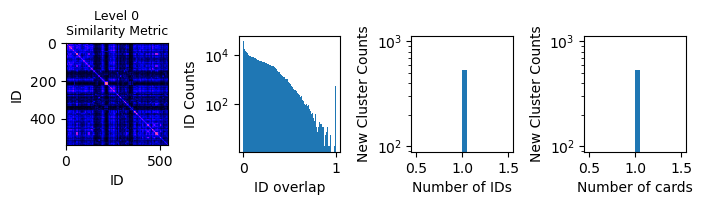

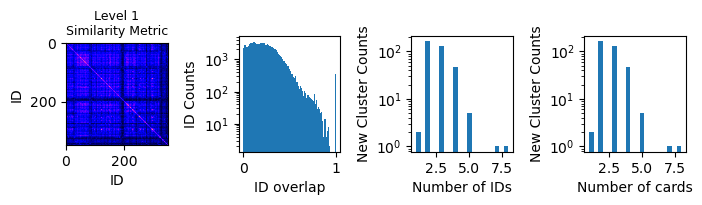

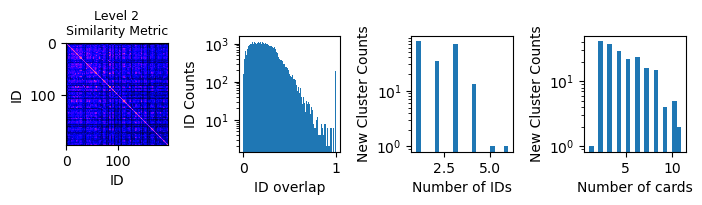

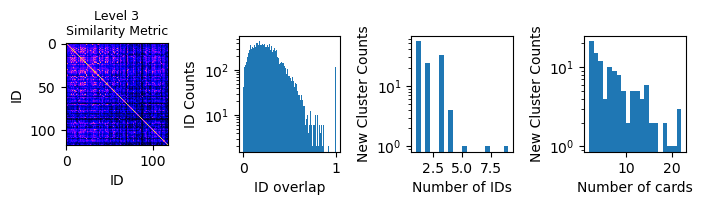

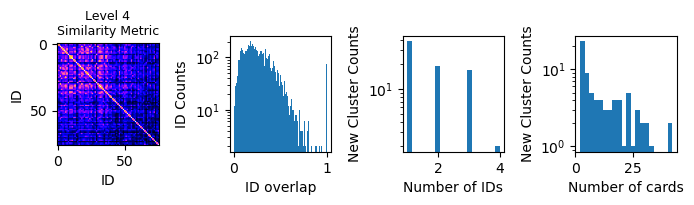

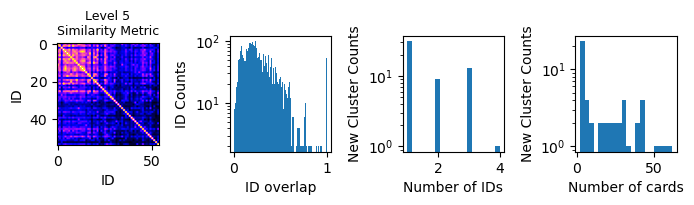

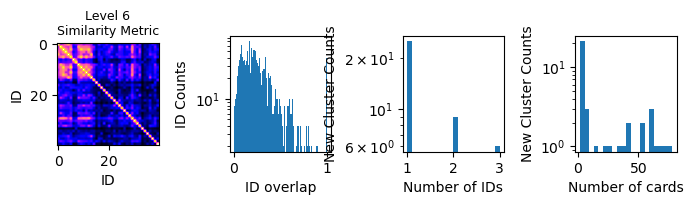

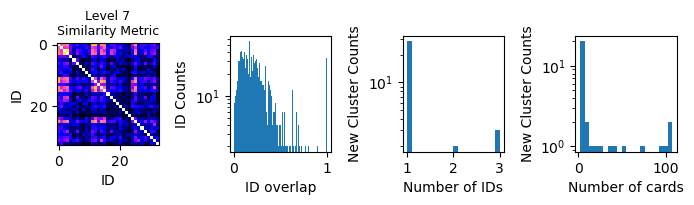

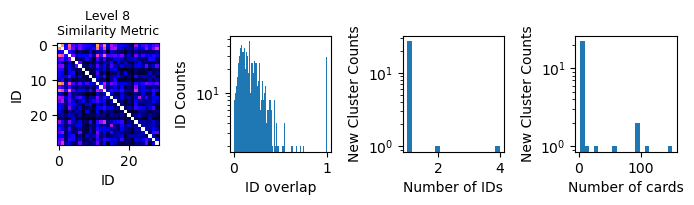

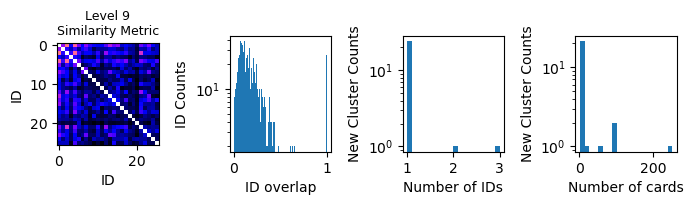

In [63]:
# Display context of whole graph clustering 

display_cluster_hierarchy_major_topics(cluster_hierarchy_meta_data, max_levels_to_display=5)
display_cluster_hierarchy_process_of_calculation(cluster_hierarchy_meta_data)

In [40]:
# Display context of a single cluster or card 

target_hierarchy_level = 1
target_cluster_ID = 3
display_cluster_hierarchy_of_cluster(cluster_hierarchy_meta_data, target_hierarchy_level, target_cluster_ID)

Grandparents
 Level: 3  ID: 36  Size: 11  Topics: Python, Data Structure, Programming, Information  ----- Numpy, File, File Access, Array
 Level: 3  ID: 23  Size: 14  Topics: Data Structure, Python, Programming, List  ----- Numpy, Array, Key-Value Pair, Finding Object
Parents
 Level: 2  ID: 42  Size: 7  Topics: Data Structure, Python, List, Problem Solving  ----- Numpy, Key-Value Pair, Indexing, Dict.items()
    Siblings
    Level: 1  ID: 250  Size: 2  Topics: Data Structure, Python, Tuple, Problem Solving  ----- Key-Value Pair, Indexing, Dict.items(), Dict
    Level: 1  ID: 26  Size: 4  Topics: Data Structure, Python, Problem Solving, List  ----- Numpy, Numeracy, Motivated Numeracy, Mylist
    Self
    Level: 1  ID: 3  Size: 5  Topics: Python, Data Structure, Programming, List  ----- Numpy, Iterator, Next, Iter
       Children
       Level: 0  ID: 470  Size: 1  Topics: Python, Programming, Data, List  ----- Numpy, Scientific Computing, Manipulation, 3D Printing
       Level: 0  ID: 43

### Explore cluster overlaps

In [45]:

# Get a list of embedding vectors from all clusters, with IDs

def get_all_unique_cluster_emb_vecs(cluster_hierarchy_meta_data):
    
    # This also removes non-unique clusters (ones that appear unchanged at multiple hierarchy levels, 
    # and it replaces them with only the lowest hierarchy where they appear. 
    
    [hierarchy_of_significant_clusters_IDgroups_list, 
     hierarchy_of_significant_clusters_cardIDs_list,
     hierarchy_of_emb_vec_lists,
     hierarchy_of_similarity_metrics]  = cluster_hierarchy_meta_data
    
    significant_clusters_unique_tuple_id_list = [] # for checking if this exact cluster is already found        
    all_unique_cluster_emb_vecs = {}
    for hierarchy_level in range(len(hierarchy_of_emb_vec_lists)):  # goes from low to high 
        
        unique_tuple_cardID_list_this_level = {(hierarchy_level, cluster_ID): tuple(sorted(cardIDs_list)) for cluster_ID, cardIDs_list 
                                       in enumerate(hierarchy_of_significant_clusters_cardIDs_list[hierarchy_level])}
        
        cluster_emb_vecs_this_level = {(hierarchy_level, cluster_ID): emb_vec for cluster_ID, emb_vec 
                                       in enumerate(hierarchy_of_emb_vec_lists[hierarchy_level]) 
                                      if not (unique_tuple_cardID_list_this_level[(hierarchy_level, cluster_ID)] 
                                              in significant_clusters_unique_tuple_id_list)}
        all_unique_cluster_emb_vecs.update(cluster_emb_vecs_this_level)
        
        # Update list of unique ideas not to use in future. 
        significant_clusters_unique_tuple_id_list.extend(list(unique_tuple_cardID_list_this_level.values()))
    
    return all_unique_cluster_emb_vecs

def get_all_card_counts_over_unique_clusters(cluster_hierarchy_meta_data, all_unique_cluster_emb_vecs, knowledgeGraph):
    
    # This also removes non-unique clusters (ones that appear unchanged at multiple hierarchy levels, 
    # and it replaces them with only the lowest hierarchy where they appear. 
    
    [hierarchy_of_significant_clusters_IDgroups_list, 
     hierarchy_of_significant_clusters_cardIDs_list,
     hierarchy_of_emb_vec_lists,
     hierarchy_of_similarity_metrics]  = cluster_hierarchy_meta_data
    
    all_card_counts = [{k: 0.0 for k in list(knowledgeGraph.cards.keys())} for _ in range(len(hierarchy_of_similarity_metrics))]
    
    for hierarchy_level, cluster_ID in all_unique_cluster_emb_vecs.keys():
        cluster_cardIDs_list = hierarchy_of_significant_clusters_cardIDs_list[hierarchy_level][cluster_ID]
        for _cardID in cluster_cardIDs_list:
            all_card_counts[hierarchy_level][_cardID] += 1.0
        
    return all_card_counts

all_unique_cluster_emb_vecs = get_all_unique_cluster_emb_vecs(cluster_hierarchy_meta_data)
all_card_counts = get_all_card_counts_over_unique_clusters(cluster_hierarchy_meta_data, all_unique_cluster_emb_vecs, kGraph)

display_dict_sorted_by_decreasing_value(all_unique_cluster_emb_vecs[(0,76)])
display_dict_sorted_by_decreasing_value(all_card_counts[6])

[('Random Distribution', 0.12964127985537088),
 ('Continuous Data', 0.1226581807343238),
 ('Grokking', 0.06418630605916346),
 ('Subspaces', 0.05984949809968133),
 ('Latent Variable Model', 0.05360491763471948),
 ('Flow Model', 0.053316390300952705),
 ('Mechanistic Interpretability', 0.040788823119029566),
 ('Layers', 0.0221376935408529),
 ('Generalization', 0.019046577487505687),
 ('Deep Unsupervised Learning', 0.01522283612665451)]
[(253, 5.0),
 (138, 5.0),
 (42, 5.0),
 (99, 4.0),
 (445, 4.0),
 (392, 4.0),
 (242, 4.0),
 (278, 4.0),
 (192, 4.0),
 (276, 4.0)]
